## Import librairies and dataset

In [6]:
#!pip install pandas seaborn matplotlib scikit-learn gensim eli5 tiktoken spacy

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import tiktoken
import eli5

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

In [84]:
import s3fs
import os

In [86]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [88]:
fs.ls("civel/diffusion/hackathon-minarm-2024/AIVSAI")

['civel/diffusion/hackathon-minarm-2024/AIVSAI/.keep',
 'civel/diffusion/hackathon-minarm-2024/AIVSAI/HC3.zip',
 'civel/diffusion/hackathon-minarm-2024/AIVSAI/all.json',
 'civel/diffusion/hackathon-minarm-2024/AIVSAI/hack_train.csv',
 'civel/diffusion/hackathon-minarm-2024/AIVSAI/train.json']

In [89]:
files = ["hack_train.csv", "train.json", "all.json"]
for file in files:
    PATH_IN = f'civel/diffusion/hackathon-minarm-2024/AIVSAI/{file}'
    fs.download(PATH_IN, f'data/{file}')

### Load dataset

In [90]:
dataset = pd.read_json("data/all.json", lines=True)
dataset.head()

,question,human_answers,chatgpt_answers,index,source
0,"Why is every book I hear about a "" NY Times # ...","[Basically there are many categories of "" Best...",[There are many different best seller lists th...,NaN,reddit_eli5
1,"If salt is so bad for cars , why do we use it ...",[salt is good for not dying in car crashes and...,[Salt is used on roads to help melt ice and sn...,NaN,reddit_eli5
2,Why do we still have SD TV channels when HD lo...,[The way it works is that old TV stations got ...,[There are a few reasons why we still have SD ...,NaN,reddit_eli5
3,Why has nobody assassinated Kim Jong - un He i...,[You ca n't just go around assassinating the l...,[It is generally not acceptable or ethical to ...,NaN,reddit_eli5
4,How was airplane technology able to advance so...,[Wanting to kill the shit out of Germans drive...,[After the Wright Brothers made the first powe...,NaN,reddit_eli5


### Preprocess

On décide de ne pas utiliser les questions, et de se fier uniquement aux réponses pour une question de simplicité.

In [9]:
human_df = pd.DataFrame({"text" : dataset["human_answers"], "generated": 0})
gpt_df = pd.DataFrame({"text" : dataset["chatgpt_answers"], "generated": 1})

human_df["text"] = human_df["text"].apply(lambda x: " ".join(x))
gpt_df["text"] = gpt_df["text"].apply(lambda x: " ".join(x))

df = pd.concat([human_df, gpt_df])
df.head()

,text,generated
0,"Basically there are many categories of "" Best ...",0
1,salt is good for not dying in car crashes and ...,0
2,The way it works is that old TV stations got a...,0
3,You ca n't just go around assassinating the le...,0
4,Wanting to kill the shit out of Germans drives...,0


## Training and test sets

In [10]:
X = df['text']
y = df['generated']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

## Entraînement: Logistic Regression

### Basic Logistic Regression

In [12]:
model = make_pipeline(CountVectorizer(), LogisticRegression(random_state=42))

In [13]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Features dimension: {len(X_train), len(model[0].vocabulary_)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

/opt/mamba/envs/nlp/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Features dimension: (38915, 77066)
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      4825
           1       0.97      0.95      0.96      4904

    accuracy                           0.96      9729
   macro avg       0.96      0.96      0.96      9729
weighted avg       0.96      0.96      0.96      9729



ConvergenceWarning: lbfgs failed to converge (status=1): STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.\
On va essayer avec un autre solver.

### Logistic Regression with another liblinear solver

In [14]:
model = make_pipeline(CountVectorizer(), LogisticRegression(random_state=42, solver = 'liblinear'))

In [15]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Features dimension: {len(X_train), len(model[0].vocabulary_)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Features dimension: (38915, 77066)
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      4825
           1       0.97      0.95      0.96      4904

    accuracy                           0.96      9729
   macro avg       0.96      0.96      0.96      9729
weighted avg       0.96      0.96      0.96      9729



In [16]:
nb_parameters = model[1].coef_.shape[0]*model[1].coef_.shape[1]
print("Model parameters:",nb_parameters)

Model parameters: 77066


## Plot confusion matrix

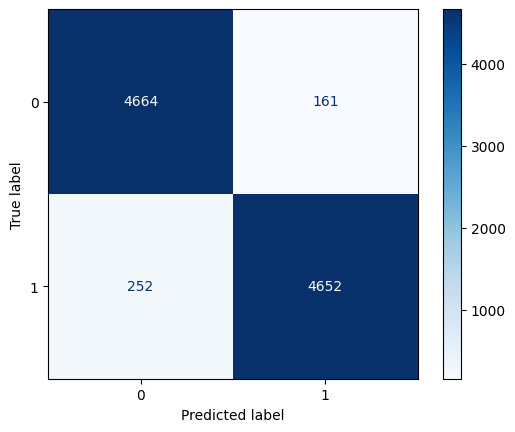

In [17]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [18]:
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9575495939973275


Avec un modèle leger et très simple on obtient déjà une très bonne précision.

# Analyse des résultats

## Importance des différentes features

In [19]:
html = eli5.show_weights(estimator=model, top=(20, 20))
html

/opt/mamba/envs/nlp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+2.231,important
+2.111,sorry
+1.663,generating
+1.534,questions
+1.510,including
+1.475,finally
+1.398,overall
+1.391,nthe
+1.320,helps
+1.292,imagine


La présence des mots 'important', 'sorry', 'generating', 'questions', 'including' tendent à faire penser que la réponse provient de chatGPT.\
Dans l'autre sens, la présence des mots 'url_0', 'ca', 'etc, 'basically' tendent à faire penser au modèle que la réponse est humaine.\
Les fautes d'orthographes, les mots familiers, les abbréviations ont l'air des features intéressantes à exploiter.

Les poids données à certaines features sont très hautes, elle impactent très fortement le modèle. Il serait judicieux d'utiliser une régulation L1/L2 pour empêcher de donner trop d'importance à une seule feature.

#### Analysons les phrases contenant les mots d'importance

In [20]:
df[df.text.str.contains("important")].groupby("generated").count()

,text
generated,
0,2222
1,9858


'important' est plus présent dans les réponses de chatGPT, est-ce que chatGPT l'utilise + ou possédons nous des données inéquitablement distributées.

In [21]:
# print 1 text whre generated = 1 and 1 text where generated = 0
df[df.text.str.contains("important")].groupby("generated").first()

,text
generated,
0,salt is good for not dying in car crashes and ...
1,There are many different best seller lists tha...


Rien de flagrant.
Mais peut remarquer que l'humain a l'air de moins utiliser de majuscules que chatGPT.

In [22]:
df[df.text.str.contains("sorry")].groupby("generated").count()

,text
generated,
0,225
1,530


In [23]:
df[df.text.str.contains("generating")].groupby("generated").count()

,text
generated,
0,110
1,210


In [24]:
df[df.text.str.contains("generating") & (df.generated == 1)].head(20)

,text,generated
219,"Freckles and other skin imperfections, like mo...",1
1205,When people say that the US government lost $2...,1
1255,"Yes, it is possible to make videos using code....",1
1502,It's important to note that Amazon is not cons...,1
1535,Charcoal and regular coal are similar in that ...,1
1565,Tattoos don't disappear because the ink that i...,1
1818,"Sure! When an airplane flies through the air, ...",1
1960,Cold fusion is a type of nuclear reaction that...,1
2037,The scrambled letters and numbers that you som...,1
2285,Nuclear fusion is a process in which atomic nu...,1


#!, network error, There was an error generatin...\
Des mauvaises data introduites par des erreurs sur chatGPT.
Il faudra les supprimer.

In [25]:
df[df.text.str.contains("error generating")].head(20)

,text,generated
2345,"!, network error, There was an error generatin...",1
2392,"!, network error, There was an error generatin...",1
3252,"!, network error, There was an error generatin...",1
3379,"!, network error, There was an error generatin...",1
3844,"!, network error, There was an error generatin...",1
6702,!network errorThere was an error generating a ...,1
6703,!Only one message at a time. Please allow any ...,1
7312,!network errorThere was an error generating a ...,1
7313,!Only one message at a time. Please allow any ...,1
7706,!network errorThere was an error generating a ...,1


In [26]:
df[df.text.str.contains("error generating")].groupby("generated").count()

,text
generated,
1,98


98 mauvaises data.

In [27]:
df[df.text.str.contains(" ca ")].groupby("generated").count()

,text
generated,
0,3547
1,2


In [28]:
df[df.text.str.contains(" ca ")].groupby("generated").first()

,text
generated,
0,The way it works is that old TV stations got a...
1,Why ca n't we eat other people ? I get the mor...


Bizarre une faute d'orthographe par chatGPT.

# Preprocess V2
On va supprimer les données dupliquées, les mauvaises données dues à une erreur de l'API chatGPT (error generating).

In [29]:
print("Taille avant suppression:", len(df))

Taille avant suppression: 48644


In [30]:
df.drop_duplicates(inplace=True)
print("Taille après suppression des doublons:", len(df))

Taille après suppression des doublons: 45749


In [31]:
df = df[~df.text.str.contains("error generating")]
print("Taille après des erreurs API chatGPT:", len(df))

Taille après des erreurs API chatGPT: 45696


In [32]:
X = df['text']
y = df['generated']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Entraînement V2

Entraînement sur les data avec le nouveau préprocessing.\
Cross validation.\
Régularisation pour empêcher un poids d'être trop important.\
GridSearch pour trouver les meilleurs hyperparamètres (taille des n-grams pour le tf-idf, lowercase ou non, learning rate, type de regularisation).

## Ensembling

In [33]:
log_clf = LogisticRegression(random_state=42, max_iter=1000)
nb_clf = MultinomialNB()

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('nb', nb_clf)], voting='soft')

model = make_pipeline(CountVectorizer(), voting_clf)

## Cross validation

In [34]:
scoring = 'f1_macro'
scores = cross_val_score(model, X, y, cv=5, scoring=scoring, n_jobs = -1)
print(f"Mean {scoring}: {scores.mean()}")
print(f"Standard deviation {scoring}: {scores.std()}")

Mean f1_macro: 0.9135957161390627
Standard deviation f1_macro: 0.04001030317770362


## Optimize hyperparameters using Grid Search

In [35]:
# Can take up to 20 minutes to run
# model = make_pipeline(CountVectorizer(), LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear'))

# param_grid = {
#     'countvectorizer__ngram_range': [(1, 1), (2, 2)], # (3,3) is too taxing on memory
#     'countvectorizer__lowercase': [True, False],
#     'logisticregression__C': [0.001, 0.01, 0.1, 1],
#     'logisticregression__penalty': ['l1', 'l2'],
# }

# grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# print("Best parameters:", grid_search.best_params_)
# print("Best cross-validation score:", grid_search.best_score_)

# best_model = grid_search.best_estimator_
# test_score = best_model.score(X_test, y_test)
# print("Test set score:", test_score)

Les meilleurs résultats ont été obtenus avec : \

Fitting 5 folds for each of 72 candidates, totalling 360 fits\
Best parameters: {'countvectorizer__lowercase': False, 'countvectorizer__ngram_range': (2, 2), 'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}\
Best cross-validation score: 0.9716234041353873\
Test set score: 0.9733785589474766

In [36]:
model = make_pipeline(CountVectorizer(ngram_range=(2,2), lowercase=False), LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear', C=0.1, penalty='l2'))

In [37]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Features dimension: {len(X_train), len(model[0].vocabulary_)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Features dimension: (36556, 1824656)
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      4482
           1       0.99      0.97      0.98      4658

    accuracy                           0.98      9140
   macro avg       0.98      0.98      0.98      9140
weighted avg       0.98      0.98      0.98      9140



In [38]:
nb_parameters = model[1].coef_.shape[0]*model[1].coef_.shape[1]
print("Model parameters:",nb_parameters)

Model parameters: 1824656


Avec un modèle plus lourd mais toujours simple (sans deep learning) on garde une très bonne précision.

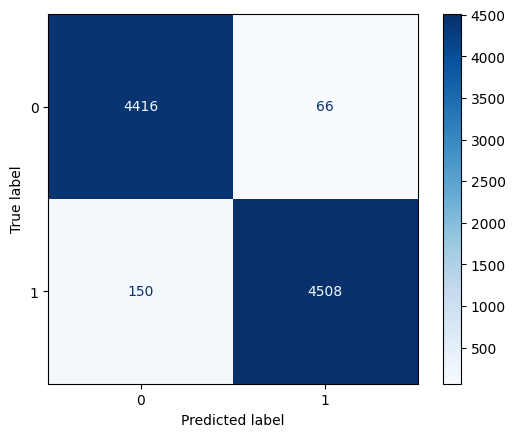

In [39]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Textes que le modèle a mal prédis

In [40]:
df.iloc[y_test[y_test != y_pred].index]

,text,generated
20180,The websites of the most publicly traded compa...,0
18564,"Data analysis is a process of inspecting, cle...",0
19906,Many of the above comments are correct about i...,0
6149,It 's not an explosion . It 's a loud boom tha...,0
3429,"In the days of typewriters , the keys were alp...",0
...,...,...
7685,[ Here 's a video of an F-4 Phantom jet going ...,0
18968,The European Commission (EC) is the executive ...,0
4258,The hydropower waterfall 's water will hit the...,0
7525,You 're missing the 22 chromosomes that are n'...,0


# Analyse du modèle

In [41]:
html = eli5.show_weights(estimator=model, top=(20, 20))
html

/opt/mamba/envs/nlp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+1.313,important to
+1.079,Does that
+0.957,helps to
+0.857,This can
+0.843,because it
+0.842,sorry but
+0.806,It important
+0.803,because they
+0.752,When you
+0.736,possible that


L'importance des poids unique est bien réduite.\
'Important to' fait fortement penser à une réponse de chatGPT.\
De l'autre côté la formulation moins soutenue et les fautes de grammaire/orthographe.

# Rajouter l'information de la question
Sous la forme "\<Q\>: {question} \<R\> Response: {reponse}"

In [42]:
human_df = pd.DataFrame({"text" : dataset["human_answers"], "generated": 0})
gpt_df = pd.DataFrame({"text" : dataset["chatgpt_answers"], "generated": 1})

human_df["text"] = human_df["text"].apply(lambda x: " ".join(x))
human_df["text"] = "<Q>" + dataset["question"] + "<R>" + human_df["text"]

gpt_df["text"] = gpt_df["text"].apply(lambda x: " ".join(x))
gpt_df["text"] = "<Q>" + dataset["question"] + "<R>" + gpt_df["text"]

df = pd.concat([human_df, gpt_df])
df.drop_duplicates(inplace=True)
df = df[~df.text.str.contains("error generating")]
df.head()

,text,generated
0,"<Q>Why is every book I hear about a "" NY Times...",0
1,"<Q>If salt is so bad for cars , why do we use ...",0
2,<Q>Why do we still have SD TV channels when HD...,0
3,<Q>Why has nobody assassinated Kim Jong - un H...,0
4,<Q>How was airplane technology able to advance...,0


In [43]:
X = df['text']
y = df['generated']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [44]:
log_clf = LogisticRegression(random_state=42, max_iter=1000)
nb_clf = MultinomialNB()

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('nb', nb_clf)], voting='soft')

model = make_pipeline(CountVectorizer(), voting_clf)

In [45]:
scoring = 'f1_macro'
scores = cross_val_score(model, X, y, cv=5, scoring=scoring, n_jobs = -1)
print(f"Mean {scoring}: {scores.mean()}")
print(f"Standard deviation {scoring}: {scores.std()}")

Mean f1_macro: 0.894756107858214
Standard deviation f1_macro: 0.04604123049963437


In [46]:
# Can take up to 20 minutes to run
# model = make_pipeline(CountVectorizer(), LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear'))

# param_grid = {
#     'countvectorizer__ngram_range': [(1, 1), (2, 2)], # (3,3) is too taxing on memory
#     'countvectorizer__lowercase': [True, False],
#     'logisticregression__C': [0.001, 0.01, 0.1],
#     'logisticregression__penalty': ['l1', 'l2'],
# }

# grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# print("Best parameters:", grid_search.best_params_)
# print("Best cross-validation score:", grid_search.best_score_)

# best_model = grid_search.best_estimator_
# test_score = best_model.score(X_test, y_test)
# print("Test set score:", test_score)

Best parameters: {'countvectorizer__lowercase': False, 'countvectorizer__ngram_range': (2, 2), 'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}\
Best cross-validation score: 0.9721703614466234\
Test set score: 0.9718280025418343

In [47]:
model = make_pipeline(CountVectorizer(ngram_range=(2,2), lowercase=False), LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear', C=0.1, penalty='l2'))

In [48]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Features dimension: {len(X_train), len(model[0].vocabulary_)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Features dimension: (37766, 1959564)
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      4689
           1       0.98      0.96      0.97      4753

    accuracy                           0.97      9442
   macro avg       0.97      0.97      0.97      9442
weighted avg       0.97      0.97      0.97      9442



In [49]:
nb_parameters = model[1].coef_.shape[0]*model[1].coef_.shape[1]
print("Model parameters:",nb_parameters)

Model parameters: 1959564


In [50]:
html = eli5.show_weights(estimator=model, top=(20, 20))
html

/opt/mamba/envs/nlp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+1.899,like five
+1.460,Explain like
+1.444,important to
+1.025,five Sure
+0.854,helps to
+0.847,This can
+0.796,It important
+0.762,Does that
+0.708,example if
+0.701,possible that


On a la même accuracy mais le modèle a l'air de overfit, rajouter la question ne semble pas être pertinent.

Le meilleur modèle serait donc le suivant :\
```python
    model = make_pipeline(CountVectorizer(ngram_range=(2,2), lowercase=False), LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear', C=0.1, penalty='l2'))
```

# Feature engineering

TODO pyspellchecker

# Bonus lightweight model

In [66]:
# preprocess V2 data
human_df = pd.DataFrame({"text" : dataset["human_answers"], "generated": 0})
gpt_df = pd.DataFrame({"text" : dataset["chatgpt_answers"], "generated": 1})

human_df["text"] = human_df["text"].apply(lambda x: " ".join(x))
gpt_df["text"] = gpt_df["text"].apply(lambda x: " ".join(x))

df = pd.concat([human_df, gpt_df])
df.drop_duplicates(inplace=True)
df = df[~df.text.str.contains("error generating")]
df.head()

,text,generated
0,"Basically there are many categories of "" Best ...",0
1,salt is good for not dying in car crashes and ...,0
2,The way it works is that old TV stations got a...,0
3,You ca n't just go around assassinating the le...,0
4,Wanting to kill the shit out of Germans drives...,0


In [67]:
X = df['text']
y = df['generated']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [61]:
log_clf = LogisticRegression(random_state=42, max_iter=1000)
nb_clf = MultinomialNB()

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('nb', nb_clf)], voting='soft')

model = make_pipeline(CountVectorizer(), voting_clf)

In [68]:
scoring = 'f1_macro'
scores = cross_val_score(model, X, y, cv=5, scoring=scoring, n_jobs = -1)
print(f"Mean {scoring}: {scores.mean()}")
print(f"Standard deviation {scoring}: {scores.std()}")

Mean f1_macro: 0.964264038326893
Standard deviation f1_macro: 0.019126197500649957


In [69]:
# Can take up to 20 minutes to run
# model = make_pipeline(CountVectorizer(), LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear'))

# param_grid = {
#     'countvectorizer__lowercase': [True, False],
#     'logisticregression__C': [0.001, 0.01, 0.1],
#     'logisticregression__penalty': ['l1', 'l2'],
# }

# grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# print("Best parameters:", grid_search.best_params_)
# print("Best cross-validation score:", grid_search.best_score_)

# best_model = grid_search.best_estimator_
# test_score = best_model.score(X_test, y_test)
# print("Test set score:", test_score)

In [71]:
model = make_pipeline(CountVectorizer(lowercase=False), LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear', C=0.1, penalty='l2'))

In [72]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Features dimension: {len(X_train), len(model[0].vocabulary_)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Features dimension: (36556, 96501)
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      4482
           1       0.98      0.98      0.98      4658

    accuracy                           0.98      9140
   macro avg       0.98      0.98      0.98      9140
weighted avg       0.98      0.98      0.98      9140



In [73]:
nb_parameters = model[1].coef_.shape[0]*model[1].coef_.shape[1]
print("Model parameters:",nb_parameters)

Model parameters: 96501


In [78]:
hack_data = pd.read_csv("data/hack_train.csv")
hack_data["generated"] = np.where(hack_data["label"] == 0, 1, 0)
hack_data.head()

,text,label,src,generated
0,Little disclaimer: this deals with US laws and...,1,cmv_human,0
1,"Read: Mentally Retarded Downs. See, we've got ...",1,cmv_human,0
2,"If any of you frequent rbadhistory, there is a...",1,cmv_human,0
3,"I believe in a flat tax system, where everyone...",1,cmv_human,0
4,"Edit: Ok guy's, my views have been changed on ...",1,cmv_human,0


In [79]:
hack_data.drop(columns=["label", "src"], inplace=True)
hack_data.head()

,text,generated
0,Little disclaimer: this deals with US laws and...,0
1,"Read: Mentally Retarded Downs. See, we've got ...",0
2,"If any of you frequent rbadhistory, there is a...",0
3,"I believe in a flat tax system, where everyone...",0
4,"Edit: Ok guy's, my views have been changed on ...",0


In [80]:
X_test, y_test = hack_data["text"], hack_data["generated"]

In [81]:
y_pred = model.predict(X_test)

print(f"Features dimension: {len(X_train), len(model[0].vocabulary_)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Features dimension: (36556, 96501)
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.97      0.68     28741
           1       0.78      0.12      0.20     28078

    accuracy                           0.55     56819
   macro avg       0.65      0.54      0.44     56819
weighted avg       0.65      0.55      0.45     56819

